In [1]:
import warnings
from osgeo import gdal
from ipywidgets import IntProgress
import glob
import random
import cv2
import numpy as np
import tensorflow as tf
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [2]:
seed = 42
lr = 1e-4

In [3]:
import os

input_dir = "./data/Data/Dec19_image/"
target_dir = "./data/Data/Dec19_mask/"
img_size = (256, 256)
num_classes = 5
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".tif")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".tif")
    ]
)

n = 1500
input_img_paths = input_img_paths[n:]
target_img_paths = target_img_paths[n:]
input_img_paths = input_img_paths[:-n]
target_img_paths = target_img_paths[:-n]

print("Number of image samples:", len(input_img_paths))

print("Number of mask samples:", len(target_img_paths))


Number of image samples: 12762
Number of mask samples: 12762


In [4]:
def read_original_mask(path):
    img = gdal.Open(path)
    x = img.ReadAsArray()
    x = np.array(x)
    x = np.array(Image.fromarray(x.astype(np.uint8)).resize((256, 256)))
    x[np.isnan(x)] = 0
    x = np.expand_dims(x, -1)
    #x = to_categorical(x,num_classes=5)
    #x = np.asarray(x, dtype=np.float32)
    print(x.shape, "read mask")
    return x


# land - green
# high - red
# moderate - yellow
# low - black
# water - blue

def make_colour_mask(segment_mask):
    colour_table = np.zeros((256, 1, 3), dtype=np.uint8)
    colour_table[0] = [0,128,0] 
    colour_table[1] = [255,0,0]
    colour_table[2] = [255,255,0]
    colour_table[3] = [0,0,0]
    colour_table[4] = [0,0,255]

    colour_mask = cv2.applyColorMap(segment_mask, colour_table)

    return colour_mask

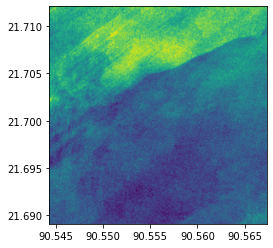

(256, 256, 1) read mask


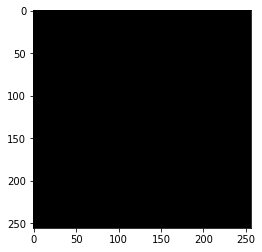

In [5]:
ind = 1512
fp = input_img_paths[ind]
img = rasterio.open(fp)
show(img)



file = target_img_paths[ind]
im = read_original_mask(file)
img = make_colour_mask(im)
plt.imshow(img)

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    diff = array.max() - array.min()
    return (array - array.min()) / diff

def read_image(path):
    raster = rasterio.open(path)
    band_2 = raster.read(1)
    band_3 = raster.read(2)
    band_4 = raster.read(3)
    
    norm_2 = normalize(band_2)
    norm_3 = normalize(band_3)
    norm_4 = normalize(band_4)
    
    x = np.dstack((norm_4, norm_3, norm_2))
    image = np.array(x)
    image = np.array(Image.fromarray((x * 255).astype(np.uint8)).resize((256, 256)).convert('RGB'))
    image[np.isnan(image)] = 0
    image = np.asarray(image, dtype=np.float32)/255.0
    #print("image")
    #print(image.shape)
    #print(image)
    return image

def read_mask(path):
    img = gdal.Open(path)
    x = img.ReadAsArray()
    x = np.array(x)
    x = np.array(Image.fromarray(x.astype(np.uint8)).resize((256, 256)))
    x[np.isnan(x)] = 0
    x = np.expand_dims(x, -1)
    x = to_categorical(x,num_classes=5)
    x = np.asarray(x, dtype=np.float32)
    # print(x.shape, "read mask")
    return x



In [7]:
im = read_mask(target_img_paths[310])
#print(im.shape)
#print(im)

In [8]:
im2 = read_image(input_img_paths[310])

print("Shape of the iamges ", im2.shape)
print("Min and Max values of the images : ", im2.max(), im2.min())


Shape of the iamges  (256, 256, 3)
Min and Max values of the images :  1.0 0.0


In [9]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


class SATDATA(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        
        for j, path in enumerate(batch_input_img_paths):
            #print(path)
            img = read_image(path)
            x[j] = img
            x[j] = np.stack(img)
            
        y = np.zeros((self.batch_size,) + self.img_size + (5,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            y[j] = read_mask(path)
         
        #print(x.shape, "  ", y.shape)
        return x, y

In [10]:
import random


# Split our img paths into a training and a validation set
val_samples = 3000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

# print(train_input_img_paths[100])
# print(train_target_img_paths[100])

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SATDATA(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SATDATA(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [11]:
print(val_gen.__len__())
print(train_gen.__len__())

93
305


In [12]:
# https://cdn-sv1.deepsense.ai/wp-content/uploads/2017/04/architecture_details.png
# https://deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/

from keras_unet import TF
if TF:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )
else:    
    from keras.models import Model
    from keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )


def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet(
    input_shape,
    num_classes=5,
    output_activation='softmax',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(5, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)   
    
    print("output data")
    print(outputs.shape)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model



# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = satellite_unet(input_shape=(256, 256, 3))
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
output data
(None, 256, 256, 5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________

In [13]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [14]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
#from keras_unet.losses import jaccard_distance

from keras.callbacks import ModelCheckpoint


val_len = val_gen.__len__()
train_len = train_gen.__len__()

steps_per_ep = train_len // batch_size

model_filename = 'Dec19.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)


model.compile(optimizer=Adam( lr = 1e-4, decay=1e-5),
              loss='categorical_crossentropy',
              metrics= [dice_coef, 'accuracy']
              )


# Train the model, doing validation at the end of each epoch.
epochs = 30
history = model.fit(train_gen, 
                    epochs=epochs, 
                    steps_per_epoch=steps_per_ep, 
                    validation_data=val_gen, 
                    callbacks=[callback_checkpoint])

Epoch 1/30
9/9 [==============================] - 1429s 172s/step - loss: 1.7231 - dice_coef: 0.6500 - accuracy: 0.3154 - val_loss: 1.3448 - val_dice_coef: 0.7183 - val_accuracy: 0.4714

Epoch 00001: val_loss improved from inf to 1.34483, saving model to Dec19.h5
Epoch 2/30
9/9 [==============================] - 1460s 175s/step - loss: 1.3127 - dice_coef: 0.7258 - accuracy: 0.4870 - val_loss: 1.3143 - val_dice_coef: 0.7450 - val_accuracy: 0.5330

Epoch 00002: val_loss improved from 1.34483 to 1.31433, saving model to Dec19.h5
Epoch 3/30
9/9 [==============================] - 1460s 176s/step - loss: 1.2140 - dice_coef: 0.7473 - accuracy: 0.5314 - val_loss: 1.0710 - val_dice_coef: 0.7854 - val_accuracy: 0.6136

Epoch 00003: val_loss improved from 1.31433 to 1.07095, saving model to Dec19.h5
Epoch 4/30
9/9 [==============================] - 1474s 177s/step - loss: 1.0911 - dice_coef: 0.7799 - accuracy: 0.6043 - val_loss: 1.0496 - val_dice_coef: 0.7905 - val_accuracy: 0.6182

Epoch 00004: 

In [15]:
print("Best Loss : ", min(history.history['loss']))
print("Best Validation Loss : ", min(history.history['val_loss']))

print("Best Accuracy : ", max(history.history['accuracy']))
print("Best Validation Accuracy : ", max(history.history['val_accuracy']))

print("Best Dice Coef : ", max(history.history['dice_coef']))

print("Best Validation Dice Coef : ", max(history.history['val_dice_coef']))


Best Loss :  0.6287556886672974
Best Validation Loss :  0.6007476449012756
Best Accuracy :  0.7700768113136292
Best Validation Accuracy :  0.7897447347640991
Best Dice Coef :  0.8685774803161621
Best Validation Dice Coef :  0.8780755400657654


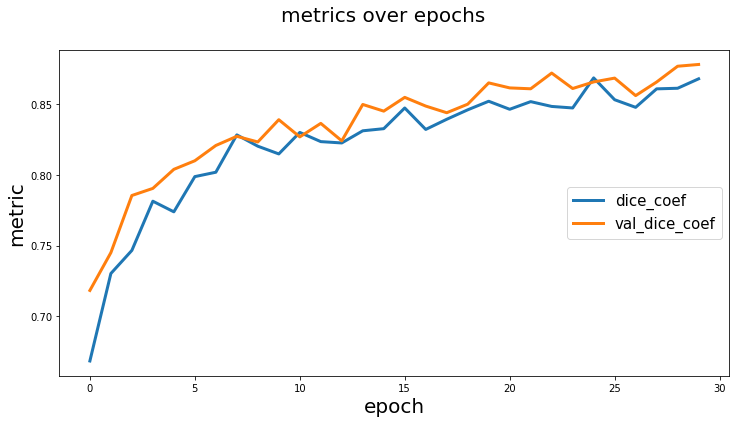

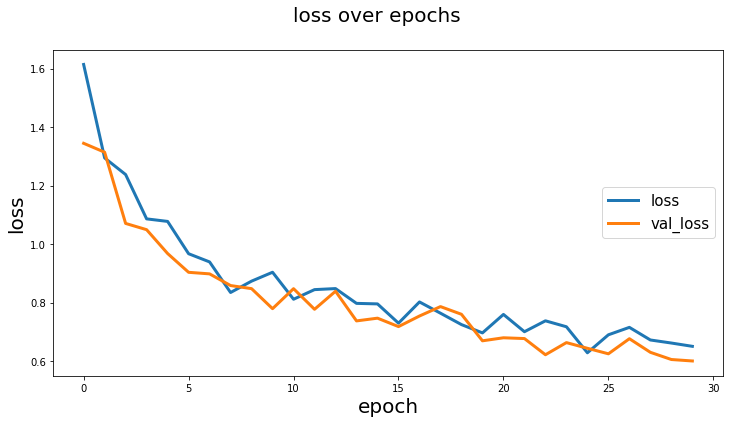

In [16]:
from keras_unet.utils import plot_segm_history

plot_segm_history(
    history, # required - keras training history object
    metrics=['dice_coef', 'val_dice_coef'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot